<a href="https://colab.research.google.com/github/BummoK/BummoK/blob/main/Autoencoder_%EB%B3%91%EB%AA%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기존 데이터셋 + 차량 7글자

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('data_before.csv')

In [ ]:
# 결측값 확인
df.isnull().sum() 

X1        0
X2        0
X3        0
X6        0
X7        0
X8        0
X9        0
X10       0
X11       0
X12       0
X13       0
X14       0
X15       0
X16       0
X17       0
target    0
dtype: int64

In [ ]:
df_second = df.copy()

In [ ]:
new_X1 = []
for i in range(len(df_second)):
    new_X1.append(df_second['X1'][i][:7])

df_second.insert(1, 'new_X1', new_X1)
df_second = df_second.drop(['X1'], axis=1)

In [ ]:
df_second['new_X1'].value_counts()

8816FLU    155757
8816FKU    111763
8816FMU    104682
7816FKU      4935
7816FLU      4336
7816FMU      2304
8816FJU      2298
Name: new_X1, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
car_encoder = LabelEncoder()

In [ ]:
df_second['new_X1'] = car_encoder.fit_transform(df_second['new_X1'])

In [ ]:
df_second = df_second.drop(['X2'], axis=1)

In [ ]:
df_second['new_X1'].value_counts()

5    155757
4    111763
6    104682
0      4935
1      4336
2      2304
3      2298
Name: new_X1, dtype: int64

## Autoencoder

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
scaler = RobustScaler()

In [ ]:
second_ae = df_second.copy()
second_ae.iloc[:,:-1] = scaler.fit_transform(second_ae.iloc[:,:-1])

In [ ]:
second_ae

,new_X1,X3,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,target
0,-2.5,-0.5,0.141207,-0.038095,0.794334,-0.031780,0.338237,0.665322,0.187080,-0.065966,-0.171270,1.104331,0.715948,-0.272466,0
1,-2.5,-0.5,0.071046,-0.019048,0.632549,0.567409,0.008911,1.095564,0.188204,0.598104,0.346213,1.929018,1.414098,-0.270995,0
2,-2.5,-0.5,0.080756,0.346032,0.284480,0.421981,0.005518,0.441728,0.189748,0.433572,0.206825,1.037080,0.882806,-0.269642,0
3,-2.5,-0.5,0.013502,-0.460317,0.762532,0.656858,0.008911,0.555442,0.190208,0.659959,0.068040,0.944658,0.820798,-0.268771,0
4,-2.5,-0.5,0.006431,2.298413,-1.055003,0.170763,0.005363,-0.712294,0.191859,0.155746,0.095054,0.087548,-0.451486,-0.268361,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386070,0.5,0.5,0.085522,0.469841,-1.618404,-1.756426,-0.086899,-0.755514,-0.767408,-1.765025,1.037901,-0.079570,-1.022391,-0.725790,0
386071,0.5,0.5,0.042850,-0.393651,0.308709,-1.040594,0.308947,0.804596,-0.766487,-1.029819,0.473461,-0.081888,-0.418968,-0.725751,0
386072,0.5,0.5,0.068390,-0.457143,0.289582,-0.534631,0.381667,0.087350,-0.766487,-0.515058,0.433811,-0.080976,-0.282481,-0.725676,0
386073,0.5,0.5,0.058294,0.434921,0.090611,0.199426,-0.090794,0.153979,-0.766487,0.209138,0.189606,1.612558,0.247642,-0.725402,0


In [ ]:
TRAINING_SAMPLE = 473
VALIDATE_SIZE = 0.2
RANDOM_SEED = 1
abnormal = second_ae[second_ae.target == 1]
normal = second_ae[second_ae.target == 0]

In [ ]:
# shuffle our training set
normal = normal.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = normal.iloc[TRAINING_SAMPLE:].drop('target', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = normal.iloc[:TRAINING_SAMPLE].append(abnormal)

In [ ]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('target', axis=1).values, X_test.target.values

In [ ]:
import random as rn

In [ ]:
# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

In [ ]:
input_dim = X_train.shape[1]
BATCH_SIZE = 512
EPOCHS = 500

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='relu'),
    
    # reconstruction / decode
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='relu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                210       
                                                                 
 dense_1 (Dense)             (None, 8)                 120       
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 8)                 4

In [ ]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=50,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

# callbacks argument only takes a list
cb = [early_stop, save_model]

In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate, X_validate)
);

Epoch 1/500
602/602 [==============================] - 2s 2ms/step - loss: 0.6211 - acc: 0.3772 - val_loss: 0.5092 - val_acc: 0.4550
Epoch 2/500
602/602 [==============================] - 1s 2ms/step - loss: 0.4759 - acc: 0.5060 - val_loss: 0.4566 - val_acc: 0.6393
Epoch 3/500
602/602 [==============================] - 1s 2ms/step - loss: 0.4455 - acc: 0.6508 - val_loss: 0.4389 - val_acc: 0.6659
Epoch 4/500
602/602 [==============================] - 1s 2ms/step - loss: 0.4368 - acc: 0.6671 - val_loss: 0.4335 - val_acc: 0.6829
Epoch 5/500
602/602 [==============================] - 1s 2ms/step - loss: 0.4320 - acc: 0.6865 - val_loss: 0.4287 - val_acc: 0.6969
Epoch 6/500
602/602 [==============================] - 1s 2ms/step - loss: 0.4282 - acc: 0.6915 - val_loss: 0.4263 - val_acc: 0.7019
Epoch 7/500
602/602 [==============================] - 1s 2ms/step - loss: 0.4263 - acc: 0.6989 - val_loss: 0.4254 - val_acc: 0.7131
Epoch 8/500
602/602 [==============================] - 1s 2ms/step - 

In [ ]:
import matplotlib.pyplot as plt

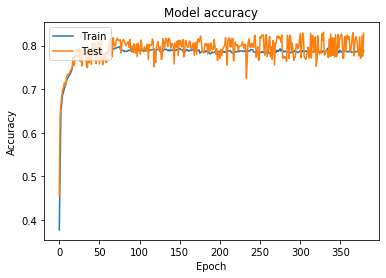

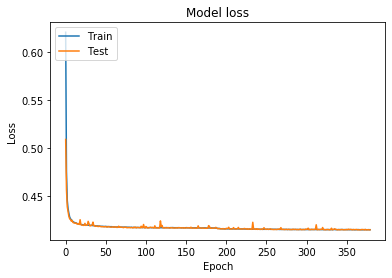

In [ ]:
# 훈련 과정 시각화 (정확도)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test)

In [ ]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

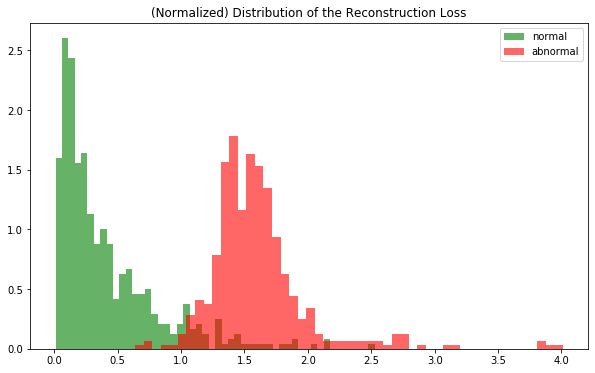

In [ ]:
normal = mse[y_test==0]
abnormal = mse[y_test==1]

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(normal, bins=50, density=True, label="normal", alpha=.6, color="green")
ax.hist(abnormal, bins=50, density=True, label="abnormal", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

### 1) Threshold = max

In [ ]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve, 
                             classification_report,
                             f1_score, precision_score, recall_score, accuracy_score)

In [ ]:
THRESHOLD = max(normal)

outliers = mse > THRESHOLD

In [ ]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve, f1_score)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [ ]:
print("Classification Report :")
print(classification_report(y_test, outliers))

Classification Report :
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       473
           1       1.00      0.04      0.07       473

    accuracy                           0.52       946
   macro avg       0.75      0.52      0.37       946
weighted avg       0.75      0.52      0.37       946



In [ ]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=2.527491663747746 are as follows:
[[473   0]
 [455  18]]

% of transactions labeled as fraud that were correct (precision): 18/(0+18) = 100.00%
% of fraudulent transactions were caught succesfully (recall):    18/(455+18) = 3.81%


In [ ]:
print("f1 score:", f1_score(y_test, outliers))
print("precision:", precision_score(y_test, outliers))
print("recall:", recall_score(y_test, outliers))
print("accuracy:", accuracy_score(y_test, outliers))

f1 score: 0.07331975560081466
precision: 1.0
recall: 0.03805496828752643
accuracy: 0.5190274841437632


### 2) Threshold = Q3 + 1.5*IQR

In [ ]:
quantile_25 = np.percentile(normal, 25)
quantile_75 = np.percentile(normal, 75)

IQR_weight = 1.5*(quantile_75 - quantile_25)

THRESHOLD = quantile_75 + IQR_weight
print(THRESHOLD)

outliers = mse > THRESHOLD

1.2533604326679433


In [ ]:
# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [ ]:
print("Classification Report :")
print(classification_report(y_test, outliers))

Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       473
           1       0.94      0.90      0.92       473

    accuracy                           0.92       946
   macro avg       0.92      0.92      0.92       946
weighted avg       0.92      0.92      0.92       946



In [ ]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=1.2533604326679433 are as follows:
[[448  25]
 [ 47 426]]

% of transactions labeled as fraud that were correct (precision): 426/(25+426) = 94.46%
% of fraudulent transactions were caught succesfully (recall):    426/(47+426) = 90.06%


In [ ]:
print("f1 score:", f1_score(y_test, outliers))
print("precision:", precision_score(y_test, outliers))
print("recall:", recall_score(y_test, outliers))
print("accuracy:", accuracy_score(y_test, outliers))

f1 score: 0.9220779220779222
precision: 0.9445676274944568
recall: 0.9006342494714588
accuracy: 0.9238900634249472


### 3) Heuristic

In [ ]:
THRESHOLD = 1

outliers = mse > THRESHOLD

In [ ]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [ ]:
print("Classification Report :")
print(classification_report(y_test, outliers))

Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       473
           1       0.91      0.98      0.94       473

    accuracy                           0.94       946
   macro avg       0.94      0.94      0.94       946
weighted avg       0.94      0.94      0.94       946



In [ ]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=1 are as follows:
[[426  47]
 [  8 465]]

% of transactions labeled as fraud that were correct (precision): 465/(47+465) = 90.82%
% of fraudulent transactions were caught succesfully (recall):    465/(8+465) = 98.31%


In [ ]:
print("f1 score:", f1_score(y_test, outliers))
print("precision:", precision_score(y_test, outliers))
print("recall:", recall_score(y_test, outliers))
print("accuracy:", accuracy_score(y_test, outliers))

f1 score: 0.9441624365482234
precision: 0.908203125
recall: 0.9830866807610994
accuracy: 0.9418604651162791
